# Loading Necessary Libraries

In [6]:
# These are standard python modules
import json, time, urllib.parse, pandas as pd
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

##  Data Acquisition

Using the example notebook, I was able to make the pageviews API request for my specififed access type. I got each article name from the rare diseases CSV file, particularly the disease column of the CSV. 

In [184]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

In [185]:
# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2024093000"    # this is likely the wrong end date
}


In [187]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

The code below reads the full CSV containing the disease names, which are also our article names. I use the disease column for the data processing step.

In [188]:
# read in csv of article titles 
df = pd.read_csv('/Users/igokhale/Downloads/rare-disease_cleaned.AUG.2024.csv')

# Data Processing

To process the data into a json file for desktop access, I created a `get_pageviews` function. This function takes in the dataframe with article names and access type the user wants to retrieve as input. It returns a json object. The function loops through each article title from the dataframe and calls the `request_pageviews_per_article` function with the current article title. If the page does not exist in views, then I print a statement telling the user that items were not found for the article and then continue to the next article. If the article exsits, then I iterate through each month adding every key-value pair except access to a list. Each element in the list is a dictionary with information for a given month. I add this list of monthly data as the value to my new dictionary with the key as the article name. The function returns a json object, which is then written to a file after the function call. 

In [190]:
def get_pageviews(df, access_type):
    '''
    Parameters
    ----------
    df : pandas dataframe with disease titles
    access_type : string specifying access type the user wants to retrieve

    Returns
    ----------
    json.loads(new_json): json object of monthly pageview data from user specified access type 
    '''
    # empty dictionary to store json object 
    new_items = {}  

    #user specified access type 
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = access_type

    #extract article titles from disease column in dataframe
    for article in df.disease.to_list():   

        #initalize empty list to store dictionariues of monthly data
        months = []

        #pageview request per article
        views = request_pageviews_per_article(article) 

        if 'items' not in views:
            print(f"No 'items' found for article: {article}")
            continue
        
        #create dictionary of monthly pageview data excluding the access key
        for month in views['items']:
            new_month = {k: v for k, v in month.items() if k != 'access'}
            months.append(new_month)

        #add to dictionary article name as key and monthly data as value
        new_items[article] = months
    
    #dump json object
    new_json = json.dumps(new_items, indent=4)

    #return json object
    return json.loads(new_json)

desktop_json = get_pageviews(df, 'desktop')

#output json object as json file
with open('rare-disease_monthly_desktop_20150701-20240930.json', 'w') as outfile:
        json.dump(desktop_json, outfile, indent=4)

#get json objects for mobile-web and mobile-app
mobile_web_json = get_pageviews(df, 'mobile-web')
mobile_app_json = get_pageviews(df, 'mobile-app')

No 'items' found for article: Sulfadoxine/pyrimethamine
No 'items' found for article: Cystine/glutamate transporter
No 'items' found for article: Trimethoprim/sulfamethoxazole
No 'items' found for article: Sulfadoxine/pyrimethamine
No 'items' found for article: Cystine/glutamate transporter
No 'items' found for article: Trimethoprim/sulfamethoxazole
No 'items' found for article: Sulfadoxine/pyrimethamine
No 'items' found for article: Cystine/glutamate transporter
No 'items' found for article: Trimethoprim/sulfamethoxazole


For the mobile access type, however, we need to combine the json objects from the mobile-web and mobile-app API calls which is defined in the function `combine_json` seen below. The function takes as input the two json objects the user wants to combine and outputs the combined json object, which is just the original json object but with summed page views from both json objects. The function creates a copy of one of the json files and then checks if both json objects are the same length. If they are, the view values are summed and written to the copy of one of the jsons. 

In [195]:
def combine_json(json1, json2):
    '''
    Parameters
    ----------
    json1 : first json object to be combined
    json2 : second json object to be combined

    Returns
    ----------
    cumulative: combined json object where pageviews are summed
    '''
    # copy first json file, the copy will be modified 
    cumulative = json1.copy()

    #check jsons have same number of entries
    if len(json1) == len(json2):
        for key in json1.keys():
            for i in range(len(json1[key])):
                views_mobile = json1[key][i]['views']
                desktop_mobile = json2[key][i]['views']

                #sum each jsons page view value
                total_views = views_mobile + desktop_mobile

                #overwrite existing view value with total views 
                cumulative[key][i]['views'] = total_views
        
    return cumulative

mobile = combine_json(mobile_web_json, mobile_app_json)

#write mobile json object to json file
with open('rare-disease_monthly_mobile_201507-202409.json', 'w') as outfile:
    json.dump(mobile, outfile, indent=4)

all_access = combine_json(mobile, desktop_json)

#write all-access json object to json file 
with open('rare-disease_monthly_cumulative_201507-202409.json', 'w') as outfile:
    json.dump(all_access, outfile, indent=4)

# Analysis

## Load necessary libraries 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load json objects 
The code below loads the desktop and mobile json objects from the json file they were written to in the previous section.

In [7]:
#load json file of monhtly desktop access data as json object 
with open('./rare-disease_monthly_desktop_201507-202409.json', 'r') as file:
    desktop = json.load(file)  

#load json file of monhtly mobile access data as json object 
with open('./rare-disease_monthly_mobile_201507-202409.json', 'r') as file:
    mobile = json.load(file) 

The function `calculate_average_views` takes in a json object as an argument. It returns a list of the articles with the maximum and minimum average monthly pageviews. The function sums the total views for a given article and then divides by the number of months to get the average monthly views. The article title (key) and average monthly page views (value) are saved in a dictionary which is then sorted by pageview. The article title with minimum and maxiumum pageviews are returned. 

In [8]:
def calculate_average_views(json_data):
    '''
    Parameters
    ----------
    json_data : json object

    Returns
    ----------
    articles : list of articles with most and least number of monthly page views i.e. ['article1', 'article2']
    '''
    #initalize empty dictionary to hold article title and average monthly page views
    averages = {}

    for disease, entries in json_data.items():

        #sum views for given article 
        total_views = sum(entry['views'] for entry in entries)

        #calculate monthly average
        average_views = total_views / len(entries)

        #add article name and average views to dictionary 
        averages[disease] = average_views

    articles = []

    #get dictionary key value pair with highest average page views
    max = dict(sorted(averages.items(), key=lambda item: item[1], reverse=True))

    #get dictionary key value pair with lowest average page views
    min = dict(sorted(averages.items(), key=lambda item: item[1], reverse=False))

    #append the key only to the articles list
    articles.append(next(iter(min)))
    articles.append(next(iter(max)))

    #return the article names in a list 
    return articles

#get article names for lowest and highest page view data for mobile and desktop
mobile_average = calculate_average_views(mobile)
desktop_average = calculate_average_views(desktop)


The `get_views_by_timestamp` function takes in a json object and the disease name (which is also the article title). It returns the timestamp (key) and pageviews (value) as a dictionary. This function is used to create graphs for a given disease.

In [9]:
def get_views_by_timestamp(json_data, disease_name):
    '''
    Parameters
    ----------
    json_data : json object
    disease_name : string specifying article name user wants to recieve monthly data about

    Returns
    ----------
    monthly article data in dictionary format {timestamp: views}
    '''
    # if the key exists in the json object
    if disease_name in json_data:

        #return dictionary of timestamp (key) and pageview data (value) for just the specified article 
        return {entry['timestamp']: entry['views'] for entry in json_data[disease_name]}
    else:
        return {}

The `make_graph` takes in the article titles the user wants to plot over time, the title of their graph, and the name of the jpeg file. It calls the `get_views_by_timestamp` function to get the monthly pageview data for a given article the user wants to visualize. The function does not return anything, but displays the plot and saves the plot as a jpeg with the user inputted filename. 

In [31]:
def make_graph(mobile_articles, desktop_articles, title, outfile): 
    '''
    Parameters
    ----------
    mobile_articles: list of mobile article names 
    desktop_articles: list of mobile article names 
    title: string plot title
    outfile: string filepath for graph, saved as jpeg

    Returns
    ----------
    None
    '''   
    plt.figure(figsize=(15,8))

    #iterate through article names to plot accessed through mobile
    for article in mobile_articles:

        #get timestamp and number of pageviews : timestamp will be x axis and pageviews is y axis
        disease = get_views_by_timestamp(mobile, article)

        #convert to datetime, to make it easier for plotting
        dates = [datetime.strptime(ts, "%Y%m%d%H") for ts in disease.keys()]
        views = disease.values()
        plt.plot(dates, views, label = article)

    #iterate through article names to plot accessed through desktop
    for article in desktop_articles:

        #get timestamp and number of pageviews : timestamp will be x axis and pageviews is y axis
        disease = get_views_by_timestamp(desktop, article)

        #convert to datetime, to make it easier for plotting
        dates = [datetime.strptime(ts, "%Y%m%d%H") for ts in disease.keys()]
        views = disease.values()
        plt.plot(dates, views, label = article)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

    if outfile != 'month_records':
        plt.legend(title = 'Article')
    else:

        #legend too large to fit on graph
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.ylabel('Page Views', fontsize = 15)
    plt.xlabel('Time in Months', fontsize = 15)
    plt.title(title, fontsize = 15)
    plt.xticks(rotation=45)
    plt.grid()

    #save image to png
    out = outfile + '.png'
    plt.savefig(out, format='png')
    
    plt.show()

    

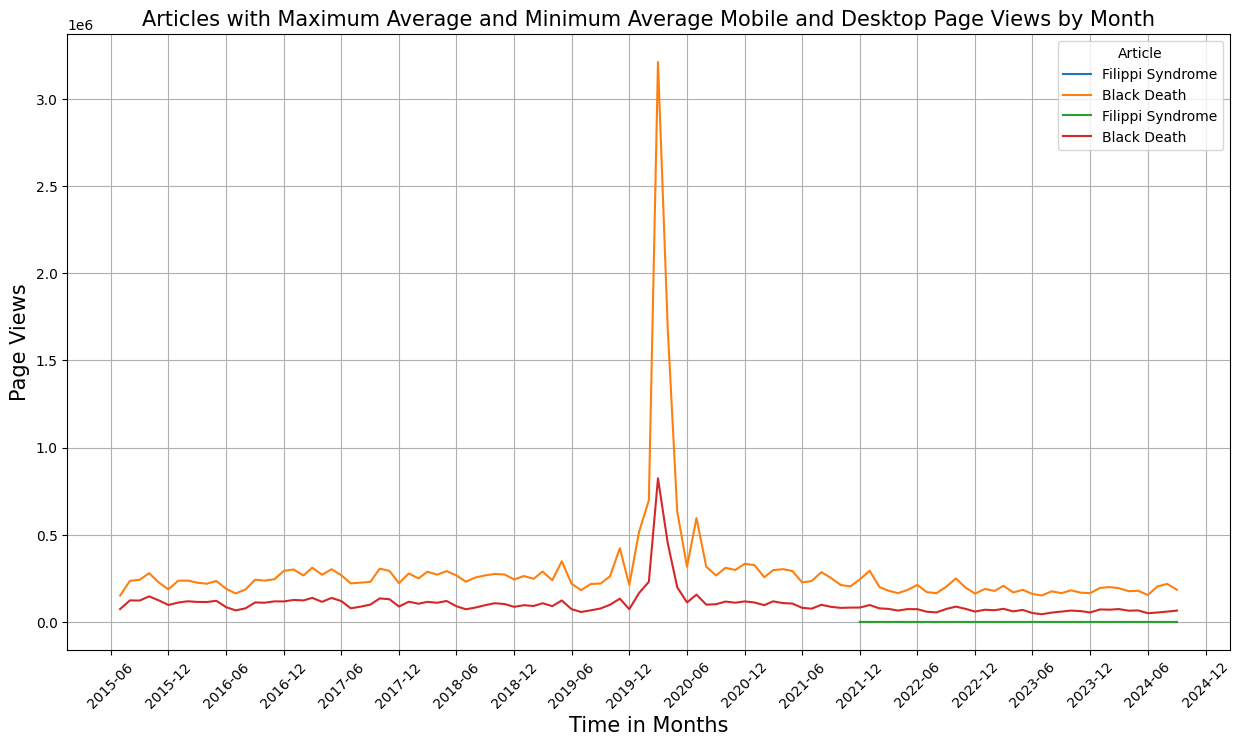

In [32]:
make_graph(mobile_average, desktop_average, 'Articles with Maximum Average and Minimum Average Mobile and Desktop Page Views by Month',
             'min_max')

The `find_peak_views_and_month` takes in a json object as input and outputs a sorted dictionary with the top 10 articles with most monthly pageviews. The key is the article name and the value is a tuple of the peak views and the month that received those views. 

In [25]:
def find_peak_views_and_month(json_data):
    '''
    Parameters
    ----------
    json_data: json object

    Returns
    ----------
    dictionary of length 10 formatted {article: (peak_views, peak_month)}
    '''   
    #initialize empty dictionary to store {article: (peak_views, peak_month)}
    peaks = {}

    #iterate through json object values
    for article, entries in json_data.items():
        peak_views = 0
        peak_month = ""
        
        #find entry with max pageviews
        for entry in entries:
            if entry['views'] > peak_views:
                peak_views = entry['views']

                #find time of max pageview
                peak_month = entry['timestamp'][:6]  
        
        #assign article title and peak views and month to dictionary 
        peaks[article] = (peak_views, peak_month)
    
    #return top 10 articles with highest peak page views
    return dict(sorted(peaks.items(), key=lambda item: item[1], reverse=True)[:10])

#get peak page views for mobile and desktop
peak_views_mobile = find_peak_views_and_month(mobile)
peak_views_desktop = find_peak_views_and_month(desktop)

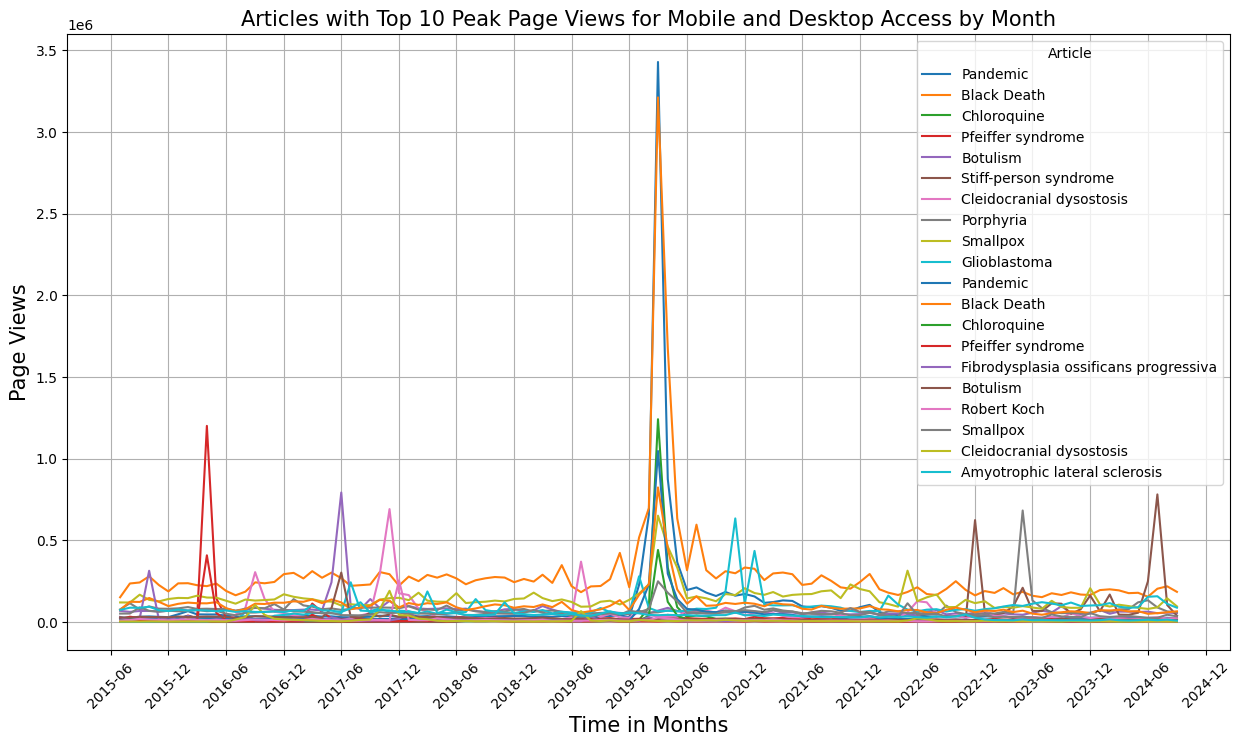

In [33]:
make_graph(peak_views_mobile, peak_views_desktop, 'Articles with Top 10 Peak Page Views for Mobile and Desktop Access by Month',
             'peak')

The `count_months_of_data` takes a json object as input and outputs a sorted dictionary of 10 articles with the least number of months available. The key is the article name and the value is number of months of data available. 

In [27]:
def count_months_of_data(data):
    '''
    Parameters
    ----------
    data: json object

    Returns
    ----------
    dictionary of length 10 formatted {article: len(data[article])}
    '''   
    #find number of months available for each article in json object
    month_len = {article: len(data[article]) for article in data}

    #return article titles and months available for the 10 articles with least months of data available
    return dict(sorted(month_len.items(), key=lambda item: item[1], reverse=False)[:10])

#get data for mobile and desktop
desktop_counts = count_months_of_data(desktop)
mobile_counts = count_months_of_data(mobile)

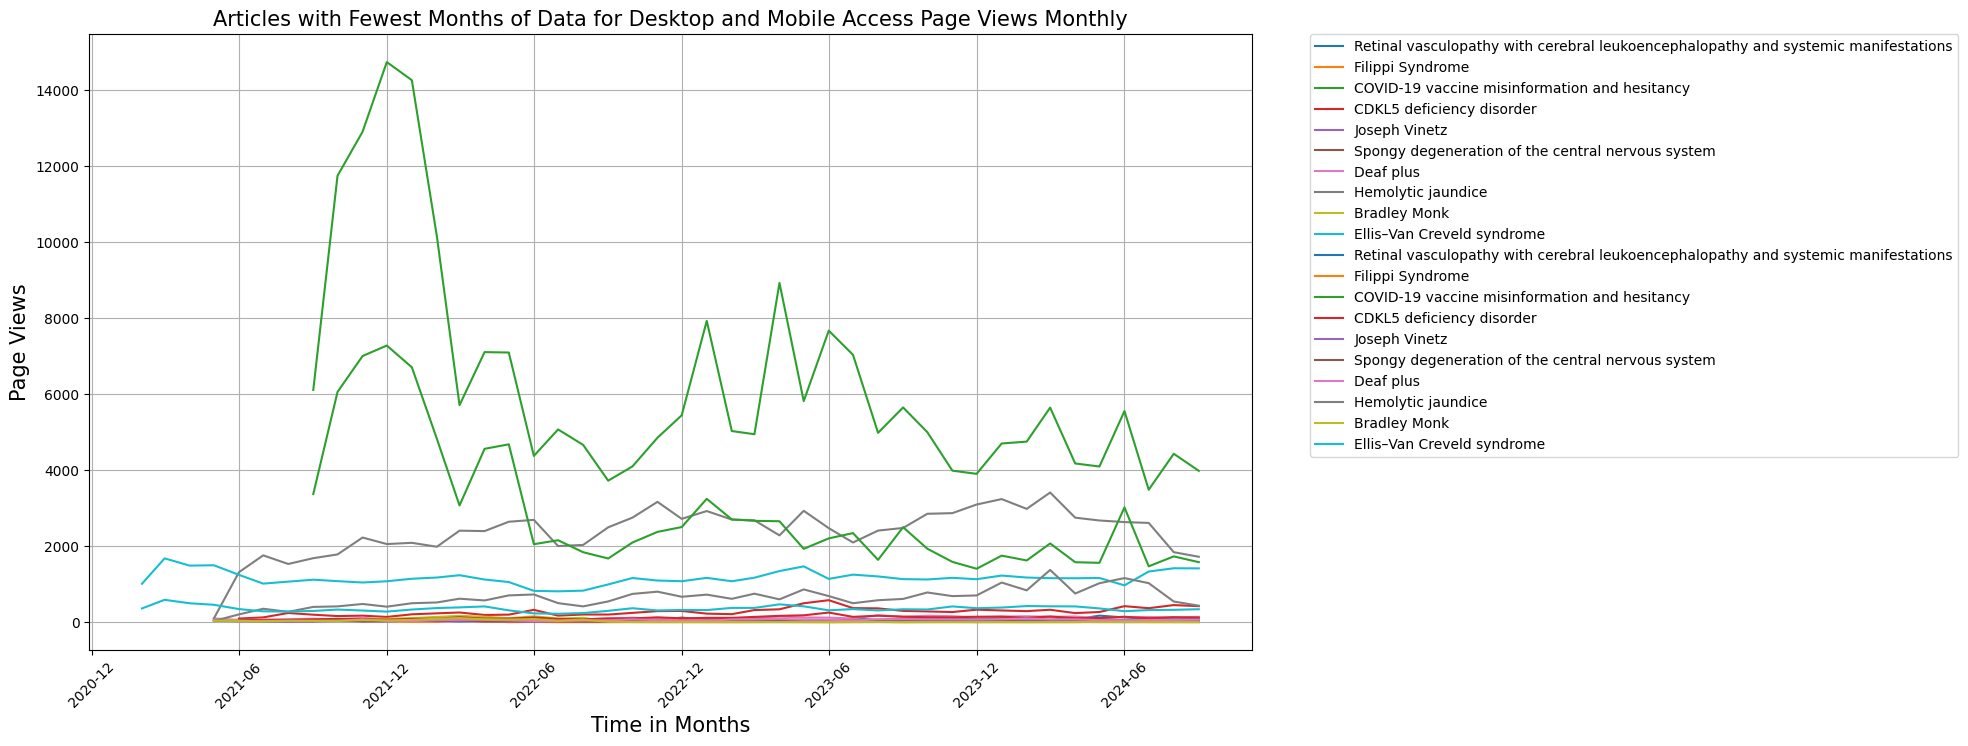

In [34]:
make_graph(mobile_counts, desktop_counts, 'Articles with Fewest Months of Data for Desktop and Mobile Access Page Views Monthly',
             'month_records')